In [1]:
# EXP 01: Ko Upsampling, Ko Scale. Model: XGBOOST, RFC, GRADIENTBOOSTING
# EXP 02: Ko Upsampling, Scale. Model : Log, Xgboost, Rfc, Grad
# Exp 03: Up Samplong bằng SMOTE, ko scale: XGBOOST, RFC, GRADIENTBOOSTING
# Exp 04: Up Sampling, Scale: Log, XGB, RFC, Grad

# Exp 01:  Upsampling, Scale: Thử với log
# Exp 2: Không Upsampling, Ko scale: thử với XgBoost

# Setup

In [2]:
!pip install xgboost
!pip install imbalanced-learn
!pip install category_encoders

     |████████████████████████████████| 86 kB 2.8 MB/s 


In [3]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
import category_encoders as ce
from imblearn.over_sampling import SMOTE, SVMSMOTE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Đọc dữ liệu

In [5]:
customer_data = pd.read_csv("/content/train.csv")

In [6]:
customer_data

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


# Xem qua dữ liệu - EDA

In [ ]:
customer_data.info()

In [ ]:
customer_data.isnull().sum()

In [9]:
object_cols = [f for f in customer_data.columns if customer_data[f].dtype == "O"]
print(object_cols)

['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']


In [ ]:
for col in object_cols:
  customer_data[col].value_counts().plot(kind='bar', figsize=(15,5))
  plt.title(col)
  plt.show()

In [11]:
numeric_cols = [f for f in customer_data.columns if customer_data[f].dtype != "O"]
print(numeric_cols)

['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


In [ ]:
for col in numeric_cols:
  customer_data[col].hist()
  plt.title(col)
  plt.show()

In [ ]:
for col in numeric_cols:
  customer_data.boxplot(column=[col])
  plt.title(col)
  plt.show()

# Tiền xử lý dữ liệu để đưa vào model

In [14]:
dataset = customer_data.copy()

In [ ]:
he = ce.HashingEncoder(cols='state')
dataset_hash = he.fit_transform(dataset)
dataset_hash

In [ ]:
dataset_hash_dummy = pd.get_dummies(dataset_hash, drop_first=True)
dataset_hash_dummy

In [ ]:
# View correlation
corr = dataset_hash_dummy.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [18]:
# Remove correlation columns
dataset_hash_dummy_drop_corr = dataset_hash_dummy.drop(columns=["voice_mail_plan_yes","total_day_charge","total_eve_charge","total_night_charge","total_intl_charge"])

# Exp 01: Upsampling = SMOTE, Scale = MINMAX và thử với Logistic

In [19]:
# SMOTE & Scale
X = dataset_hash_dummy_drop_corr.drop(["churn_yes"],axis=1)
y = dataset_hash_dummy_drop_corr['churn_yes']

# Chia train ,test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=42)

# Upsampling = SMOTE
sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train,y_train)

#Scale

scale_columns = ['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_eve_minutes', 'total_eve_calls',
       'total_night_minutes', 'total_night_calls', 'total_intl_minutes',
       'total_intl_calls', 'number_customer_service_calls']



scaler = MinMaxScaler()
scaler.fit(X_train_resample[scale_columns])
X_train_resample[scale_columns] = scaler.transform(X_train_resample[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       721
           1       0.59      0.34      0.43       129

    accuracy                           0.86       850
   macro avg       0.74      0.65      0.68       850
weighted avg       0.84      0.86      0.85       850



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


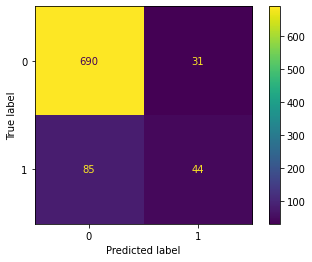

In [20]:
# Logistic Regression
model_log = LogisticRegression() 
model_log.fit(X_train_resample, y_train_resample)
y_pred = model_log.predict(X_test)

# In ra du lieu
print(classification_report( y_test, y_pred))

plot_confusion_matrix(model_log, X_test, y_test)

# Exp 2: XGBOOST, Ko Upsampling, Ko Scale

In [21]:
# SMOTE & Scale
X = dataset_hash_dummy_drop_corr.drop(["churn_yes"],axis=1)
y = dataset_hash_dummy_drop_corr['churn_yes']

# Chia train ,test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       721
           1       0.97      0.81      0.88       129

    accuracy                           0.97       850
   macro avg       0.97      0.90      0.93       850
weighted avg       0.97      0.97      0.97       850



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


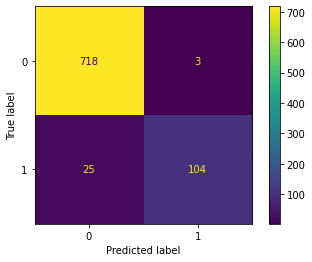

In [22]:
# XGBoost

import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_xgb.fit(X_train, y_train)


y_pred = model_xgb.predict(X_test)
# In bao cao ket qua
print(classification_report( y_test, y_pred))
plot_confusion_matrix(model_xgb, X_test, y_test)

# Submit ket qua len Kaggle

In [23]:
test = pd.read_csv("/content/test.csv")
id_submit = test['id']

In [24]:
test.drop(columns=['id'], inplace=True)

In [25]:
test_hash_state = he.fit_transform(test)
test_hash_state.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,account_length,area_code,...,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,0,1,0,0,0,0,0,0,128,area_code_415,...,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,0,1,0,0,0,0,0,0,118,area_code_510,...,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,0,0,0,0,0,0,0,1,62,area_code_415,...,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,0,0,0,0,1,0,0,0,93,area_code_510,...,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,1,0,0,0,0,0,0,0,174,area_code_415,...,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [26]:
test_dummy =  pd.get_dummies(test_hash_state,drop_first=True)
test_dummy_drop_corr = test_dummy.drop(columns=["voice_mail_plan_yes","total_day_charge","total_eve_charge","total_night_charge","total_intl_charge"])

In [27]:
test_dummy_drop_corr.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_eve_minutes', 'total_eve_calls',
       'total_night_minutes', 'total_night_calls', 'total_intl_minutes',
       'total_intl_calls', 'number_customer_service_calls',
       'area_code_area_code_415', 'area_code_area_code_510',
       'international_plan_yes'],
      dtype='object')

In [28]:
y_pred_submit = model_xgb.predict(test_dummy_drop_corr)

In [29]:
y_pred_submit

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
submit_result = pd.DataFrame({'id': id_submit,'churn': y_pred_submit})
submit_result

,id,churn
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
745,746,0
746,747,0
747,748,0
748,749,0


In [31]:
submit_result.churn.replace([0,1],['no','yes'],inplace=True)
submit_result

,id,churn
0,1,no
1,2,no
2,3,yes
3,4,no
4,5,no
...,...,...
745,746,no
746,747,no
747,748,no
748,749,no


In [32]:
submit_result.to_csv("dunglo2k1_submit.csv", index=False)